# Imports


In [1]:
!pip install ipympl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.7/515.7 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 46.9 MB/s eta 0:00:00


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

'''# TO SHOW INTERACTIVE PLOT
%matplotlib widget
from google.colab import output
output.enable_custom_widget_manager()'''

'# TO SHOW INTERACTIVE PLOT\n%matplotlib widget  \nfrom google.colab import output\noutput.enable_custom_widget_manager()'

# Loading Data

Data sets consists of multiple multivariate time series. Each data set is further divided into training and test subsets. Each time series is from a different engine – i.e., the data can be considered to be from a fleet of engines of the same type. Each engine starts with different degrees of initial wear and manufacturing variation which is unknown to the user. This wear and variation is considered normal, i.e., it is not considered a fault condition. There are three operational settings that have a substantial effect on engine performance. These settings are also included in the data. The data is contaminated with sensor noise.

The engine is operating normally at the start of each time series, and develops a fault at some point during the series. In the training set, the fault grows in magnitude until system failure. In the test set, the time series ends some time prior to system failure. The objective of the competition is to predict the number of remaining operational cycles before failure in the test set, i.e., the number of operational cycles after the last cycle that the engine will continue to operate. Also provided a vector of true Remaining Useful Life (RUL) values for the test data.

The data are provided as a zip-compressed text file with 26 columns of numbers, separated by spaces. Each row is a snapshot of data taken during a single operational cycle, each column is a different variable. The columns correspond to:
1)	unit number
2)	time, in cycles
3)	operational setting 1
4)	operational setting 2
5)	operational setting 3
6)	sensor measurement  1
7)	sensor measurement  2
...
26)	sensor measurement  26

In [3]:
train_paths = ['train_FD001.txt', 'train_FD002.txt', 'train_FD003.txt', 'train_FD004.txt']
test_paths = ['test_FD001.txt', 'test_FD002.txt', 'test_FD003.txt', 'test_FD004.txt']
rul_paths = ['RUL_FD001.txt', 'RUL_FD002.txt', 'RUL_FD003.txt', 'RUL_FD004.txt']


trainsets = []
extended_testsets = []
testsets = []

for train_path, test_path, rul_path in zip(train_paths, test_paths, rul_paths):
    trainset = pd.read_csv(train_path, sep=' ', header=None)
    testset = pd.read_csv(test_path, sep=' ', header=None)
    ruls = pd.read_csv(rul_path, sep=',', names=['value'])
    # Assign column names to the dataframe
    column_names = ['unit number', 'time (cycles)', 'operational setting 1', 'operational setting 2',
                    'operational setting 3', 'sensor measurement 1', 'sensor measurement 2',
                    'sensor measurement 3', 'sensor measurement 4', 'sensor measurement 5',
                    'sensor measurement 6', 'sensor measurement 7', 'sensor measurement 8',
                    'sensor measurement 9', 'sensor measurement 10', 'sensor measurement 11',
                    'sensor measurement 12', 'sensor measurement 13', 'sensor measurement 14',
                    'sensor measurement 15', 'sensor measurement 16', 'sensor measurement 17',
                    'sensor measurement 18', 'sensor measurement 19', 'sensor measurement 20',
                    'sensor measurement 21', 'a', 'b']
    trainset.columns = column_names
    testset.columns = column_names
    # Drop last two columns because they are empty
    trainset.drop(['a', 'b'], axis=1, inplace=True)
    testset.drop(['a', 'b'], axis=1, inplace=True)

    # Calculate the standard deviation for each column
    std_values = trainset.std()
    # Filter the columns with standard deviation of 0
    zero_std_columns = std_values[std_values == 0].index
    # Drop the columns with standard deviation of 0 from the DataFrame
    trainset = trainset.drop(zero_std_columns, axis=1)
    testset = testset.drop(zero_std_columns, axis=1)

    # Now I want to calculate the RUL for each istance in the trainset
    # Group the data by 'unit_number' and find the maximum value of 'time (cycles)'
    max_cycles = trainset.groupby('unit number')['time (cycles)'].max()

    # Create the 'RUL' column by calculating the difference between max value and 'time (cycles)'
    # Create a function to calculate RUL based on the group's maximum cycles
    def calculate_rul(row):
        unit_number = row['unit number']
        time_cycles = row['time (cycles)']
        max_cycles_unit = max_cycles[unit_number]
        rul = max_cycles_unit - time_cycles
        return rul

    # Apply the RUL calculation function to each row using apply
    trainset['RUL'] = trainset.apply(calculate_rul, axis=1)
    # 'RUL' column now contains the number of cycles to failure for each record

    # Now I want to calculate the RUL for each instance in the testset
    # Group the data by 'unit_number' and find the maximum value of 'time (cycles)'
    max_cycles_test = testset.groupby('unit number')['time (cycles)'].max()

    def calculate_test_rul(row):
        unit_number = row['unit number']
        time_cycles = row['time (cycles)']
        min_rul = ruls['value'][unit_number-1]
        max_cycles_unit = max_cycles_test[unit_number]
        rul = min_rul + max_cycles_unit - time_cycles
        return rul

    # Apply the RUL calculation function to each row using apply
    testset['RUL'] = testset.apply(calculate_test_rul, axis=1)
    # 'RUL' column now contains the number of cycles to failure for each record

    # I am creating a testset with only the last istance for each unit
    short_testset = testset.groupby('unit number').tail(1)

    trainsets.append(trainset)
    extended_testsets.append(testset)
    testsets.append(short_testset)

# Visualizing Data

By leveraging data visualization techniques, we can explore data more effectively, make informed decisions on feature selection and model design and interpret model behavior. Ultimately, data visualization contributes to better decision-making and improved machine learning outcomes.
First of all, the train sets are saved in csv files to be analyzed in KNIME.

In [ ]:
# Iterate over train_paths and trainsets to store each DataFrame as a CSV file
for path, dataset in zip(train_paths, trainsets):
    dataset.to_csv(path[:-4] + '.csv', index=False)

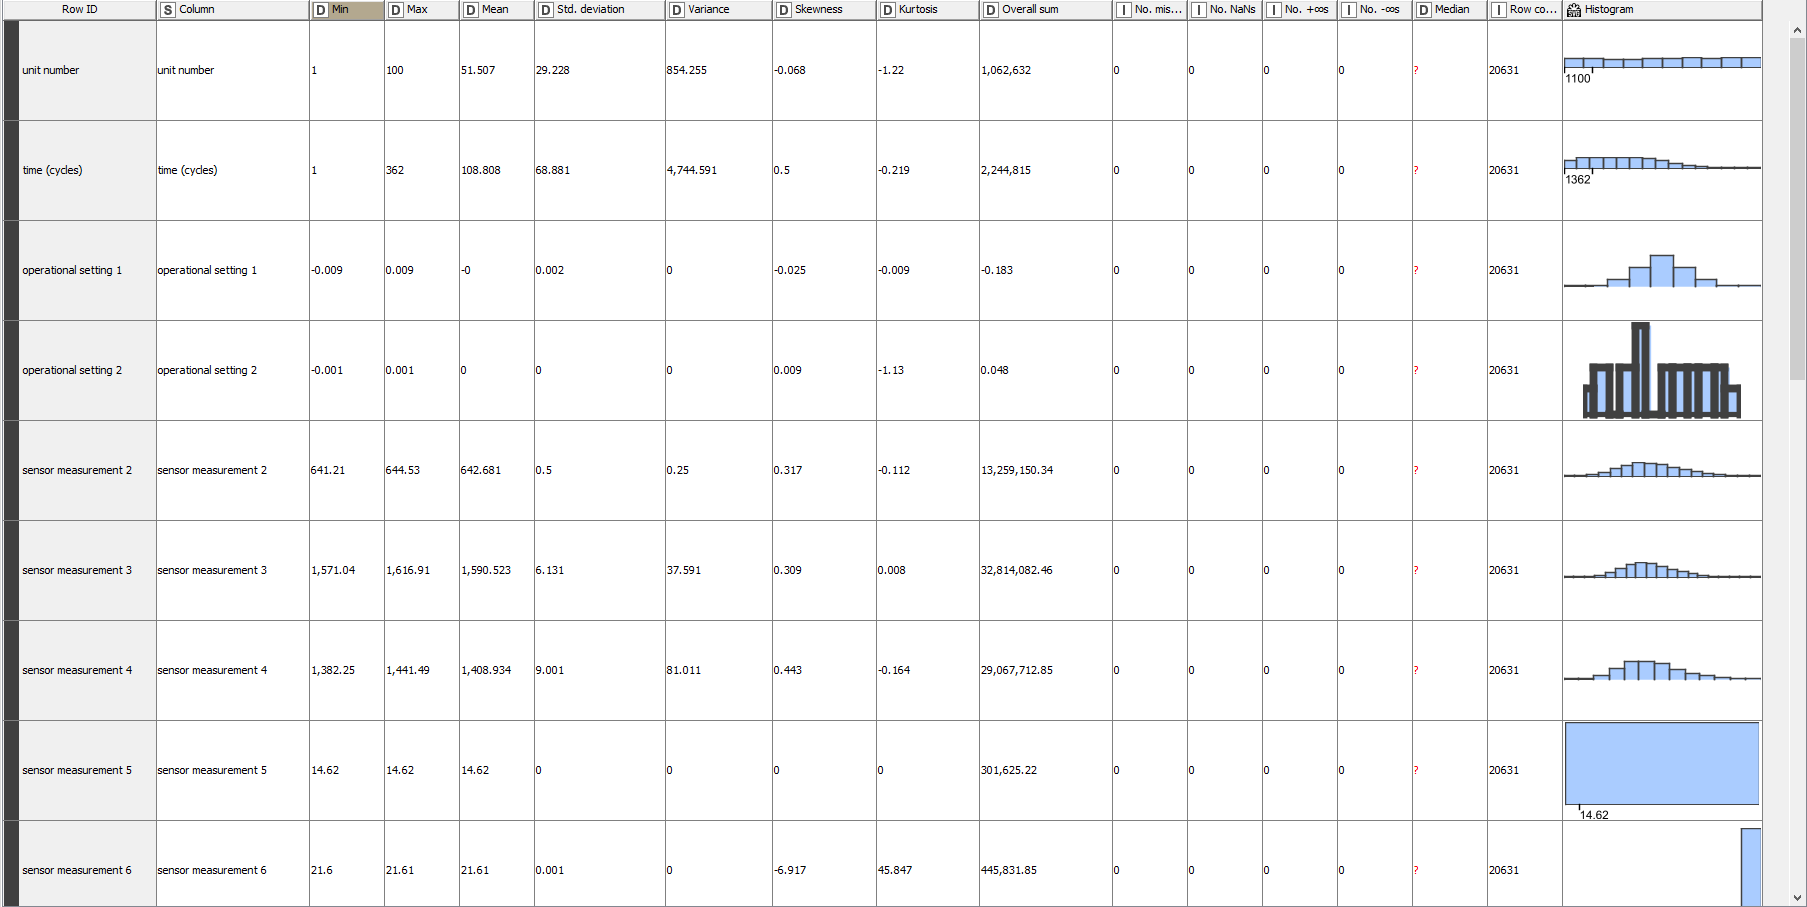

Other than basic statistics, I have computed the correlation matrix. A correlation matrix is an important tool in machine learning for understanding the relationships between variables in a dataset.

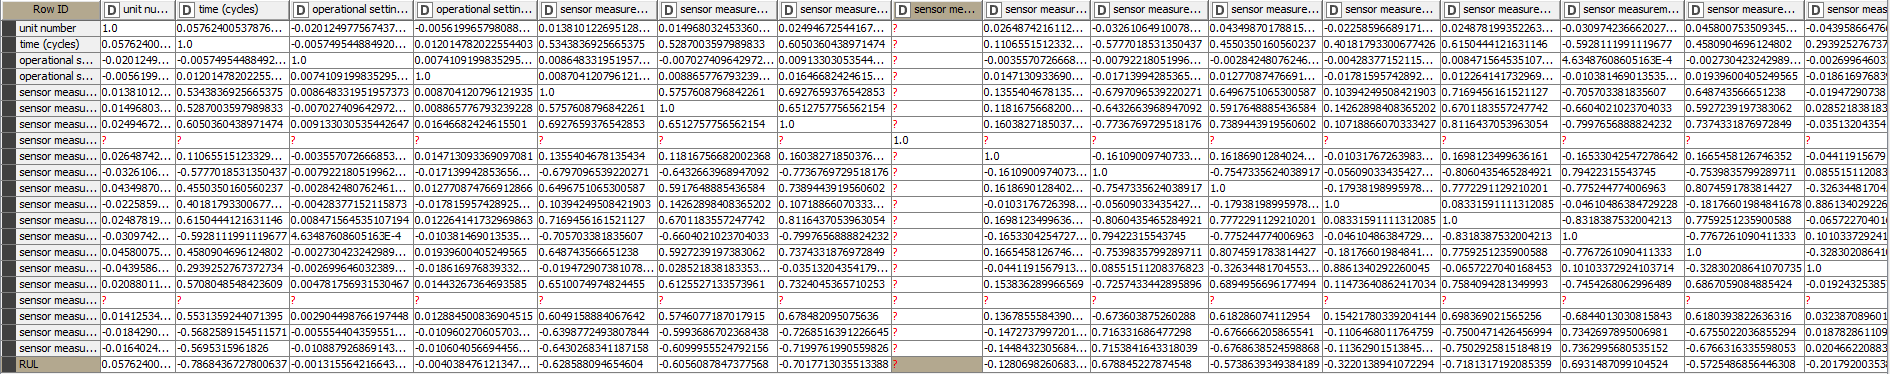

# Linear Regression

Mean absolute error: 26.123454950636805
Root mean squared error: 31.740474995218996


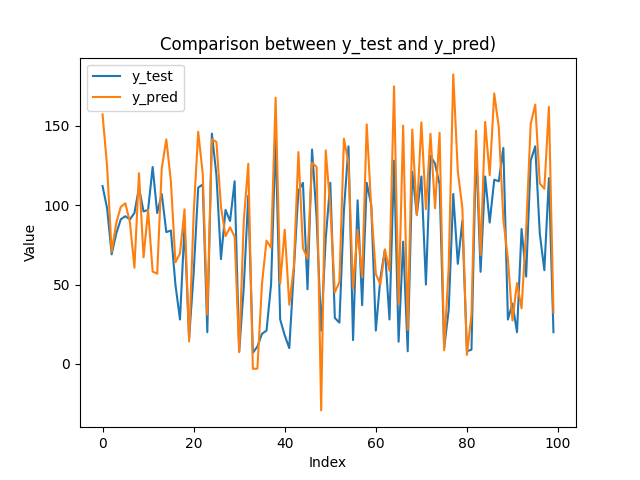

Mean absolute error: 26.317859687077224
Root mean squared error: 32.02215167976779


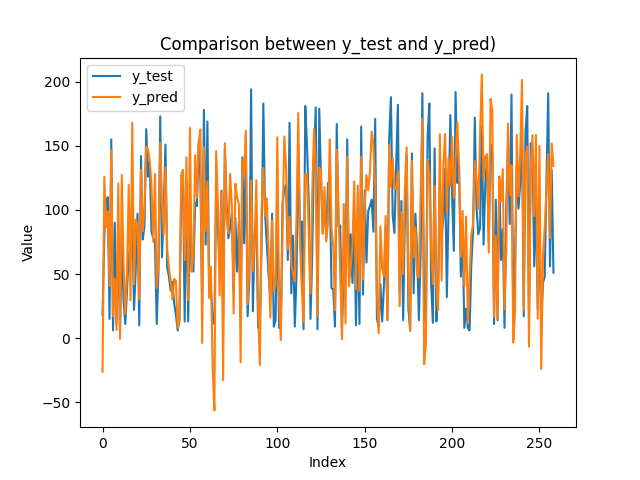

Mean absolute error: 46.29838529152272
Root mean squared error: 57.40349638726033


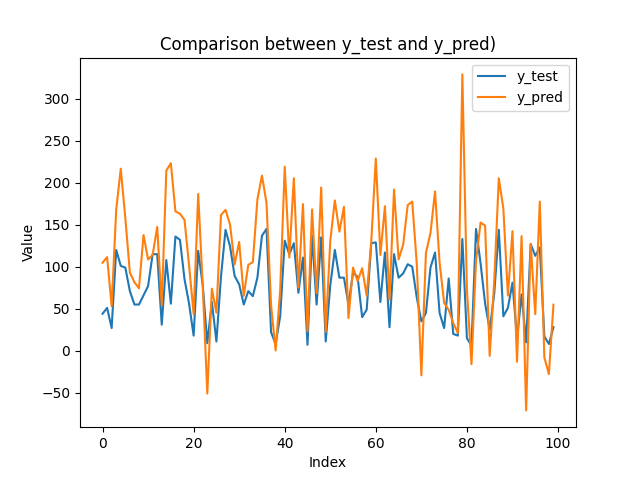

Mean absolute error: 38.17519713146674
Root mean squared error: 46.4715657539438


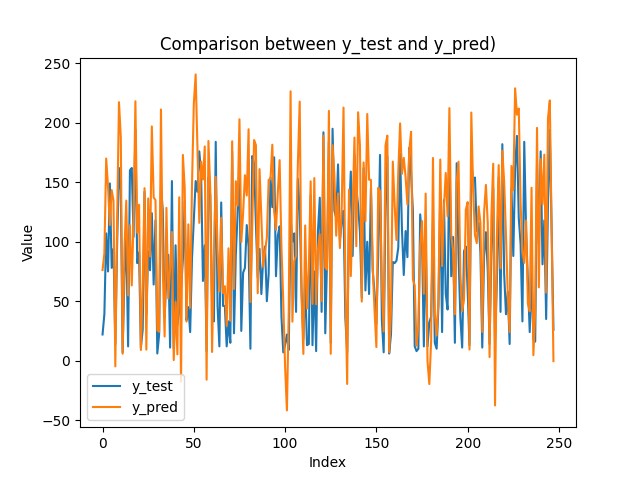

In [ ]:
lin_models = []
for i, (trainset, testset) in enumerate(zip(trainsets, testsets)):
    # Split the dataset into input features (X) and the target variable (y)
    y_train = trainset['RUL']
    X_train = trainset.drop('RUL', axis=1)
    y_test = testset['RUL']
    X_test = testset.drop('RUL', axis=1)

    # Create an instance of the LinearRegression model
    model = LinearRegression()

    # Train the linear regression model using the entire dataset
    model.fit(X_train, y_train)

    # Make predictions using the trained model
    y_pred = model.predict(X_test)

    # Evaluate the model's performance
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)

    print(f'Mean absolute error: {mae}')
    print(f'Root mean squared error: {rmse}')

    # Generate x-axis values based on the array length
    x = np.arange(len(y_test))

    # Create a new figure for each iteration
    plt.figure(i)

    # Plot the arrays
    plt.plot(x, y_test, label='y_test')
    plt.plot(x, y_pred, label='y_pred')

    # Add labels and title
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title(f'Comparison between y_test and y_pred)')

    # Add legend
    plt.legend()

    # Display the plot
    plt.show()

    # Store the model in the models list
    lin_models.append(model)

# Random Forest

  param_n_estimators  mean_test_score  rank_test_score
2                200        31.928704                1
1                100        31.966935                2
0                 50        32.119040                3
Test mean absolute error:: 24.397449999999996
Test root mean squared error: 35.80883927538004


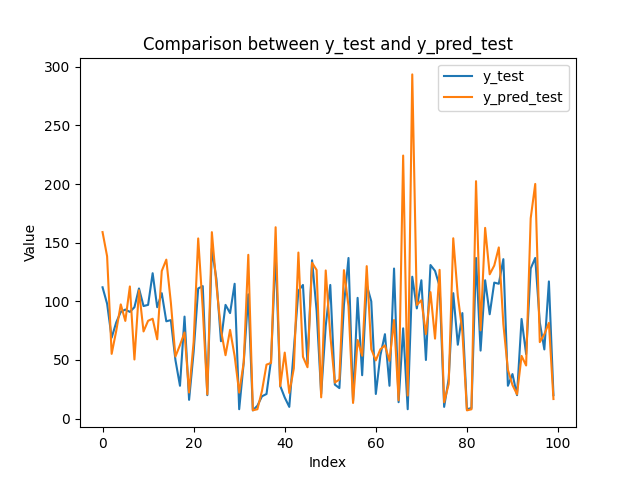

  param_n_estimators  mean_test_score  rank_test_score
1                100        32.898670                1
0                 50        32.913307                2
2                200        32.922913                3
Test mean absolute error:: 23.93455598455598
Test root mean squared error: 35.47085196865505


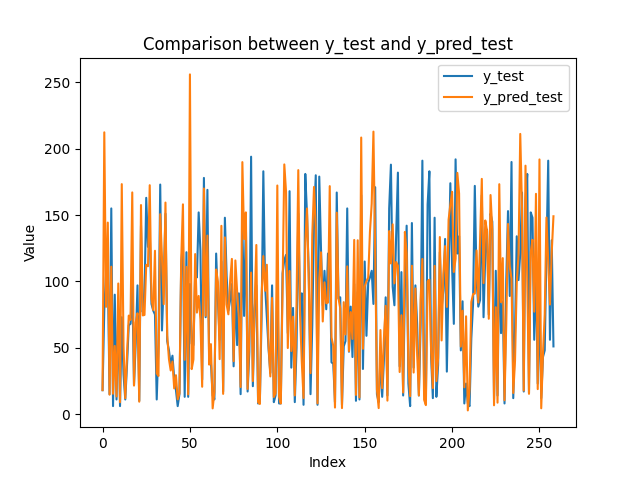

  param_n_estimators  mean_test_score  rank_test_score
1                100        41.035227                1
2                200        41.122408                2
0                 50        41.205308                3
Test mean absolute error:: 24.671700000000005
Test root mean squared error: 34.57863743700726


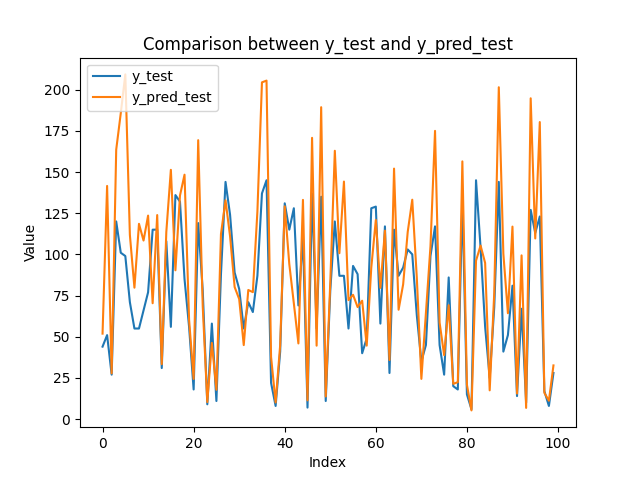

  param_n_estimators  mean_test_score  rank_test_score
2                200        42.900114                1
1                100        42.930664                2
0                 50        42.979253                3
Test mean absolute error:: 28.296290322580642
Test root mean squared error: 39.75266333641948


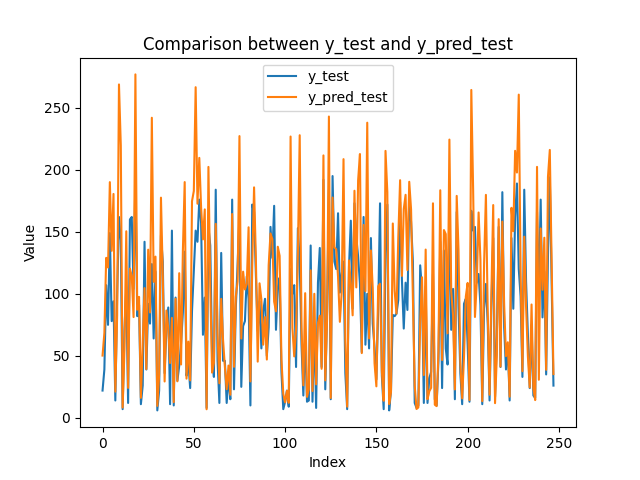

In [ ]:
forest_models = []

# Define the values of n_estimators to try
n_estimators_values = [50, 100, 200]

# Create an empty list to store the performance results
results = []

for i, (trainset, testset) in enumerate(zip(trainsets, testsets)):
    # Split the dataset into training and test sets
    y_train = trainset['RUL']
    X_train = trainset.drop('RUL', axis=1)

    y_test = testset['RUL']
    X_test = testset.drop('RUL', axis=1)

    # Create an instance of the RandomForestRegressor model
    model = RandomForestRegressor(random_state=10)

    # Define the grid of hyperparameters to search over
    param_grid = {'n_estimators': n_estimators_values}

    # Perform grid search with cross-validation to find the best hyperparameters
    grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_absolute_error', cv=5)
    grid_search.fit(X_train, y_train)

    # Get the results of the grid search
    cv_results = pd.DataFrame(grid_search.cv_results_)
    cv_results = cv_results[['param_n_estimators', 'mean_test_score', 'rank_test_score']]
    # Negate the values in the 'mean_test_score' column
    cv_results['mean_test_score'] = -cv_results['mean_test_score']
    cv_results = cv_results.sort_values(by='rank_test_score')
    print(cv_results)

    # Get the best model from the grid search
    best_model = grid_search.best_estimator_

    # Retrain the best model using the entire training set
    best_model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred_test = best_model.predict(X_test)

    # Evaluate the model's performance on the test set
    mae_test = mean_absolute_error(y_test, y_pred_test)
    rmse = mean_squared_error(y_test, y_pred_test, squared=False)
    print("Test mean absolute error::", mae_test)
    print("Test root mean squared error:", rmse)

    # Generate x-axis values based on the array length
    x_test = np.arange(len(y_test))

    # Create a new figure for each iteration
    plt.figure(i+4)

    # Plot the test set predictions
    plt.plot(x_test, y_test, label='y_test')
    plt.plot(x_test, y_pred_test, label='y_pred_test')

    # Add labels and title
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title('Comparison between y_test and y_pred_test')

    # Add legend
    plt.legend()

    # Display the plot
    plt.show()

    # Store the best model in the models list
    forest_models.append(best_model)

# Deep Learning: LSTM

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1487 - mae: 0.2515
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Model: 1
Test mean absolute error: 18.356578561067582
Test root mean squared error: 29.30279032518855


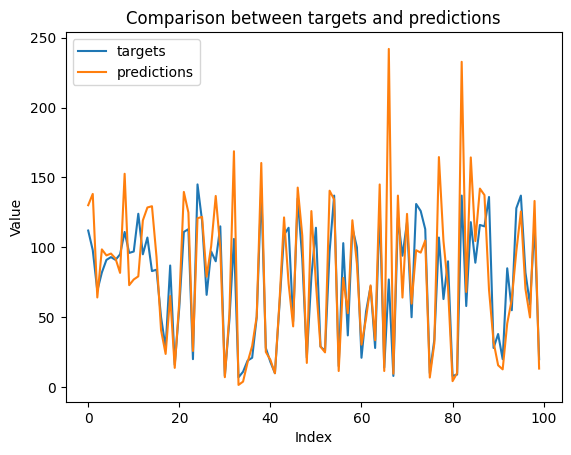

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1577 - mae: 0.3015
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step
Model: 2
Test mean absolute error: 21.249643941643615
Test root mean squared error: 28.233592425300152


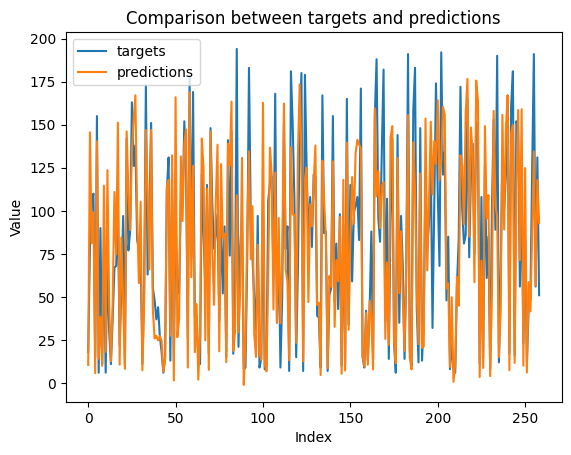

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1021 - mae: 0.2157
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step
Model: 3
Test mean absolute error: 22.597442779541016
Test root mean squared error: 34.061738925360714


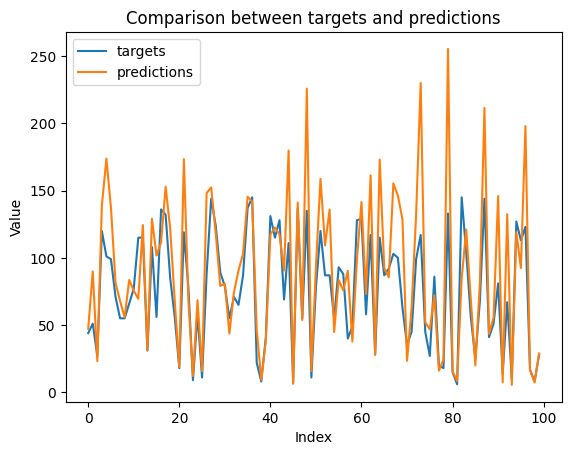

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2004 - mae: 0.3294 


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step
Model: 4
Test mean absolute error: 29.047434251154623
Test root mean squared error: 39.97674287684084


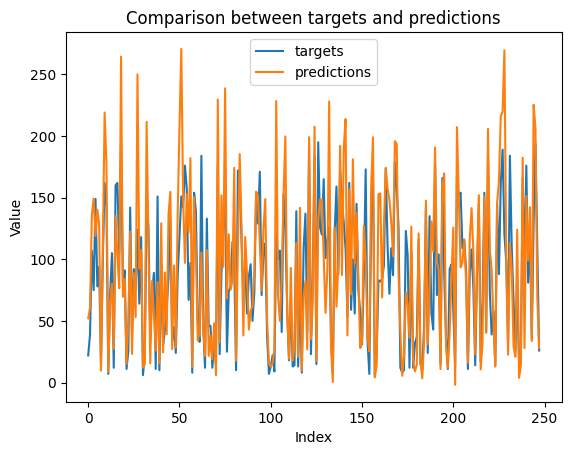

In [8]:
# Define the window size for the LSTM model
window_size = 32
lstm_models = []  # List to store trained models
scalers = []  # List to store corresponding scalers

for trainset in trainsets:
    # Normalize the input data
    scaler = StandardScaler()
    scaled_train_data = scaler.fit_transform(trainset.iloc[:, 1:-1])

    # Normalize the labels (RUL)
    label_scaler = StandardScaler()
    scaled_labels = label_scaler.fit_transform(trainset['RUL'].values.reshape(-1, 1))

    # Prepare the training data for each unit number
    X_train, y_train = [], []
    max_unit_number = trainset['unit number'].max()
    y_index = 0
    for unit_number in range(1, max_unit_number + 1):
        unit_data = scaled_train_data[trainset['unit number'] == unit_number]

        for i in range(len(unit_data)):
            if i < window_size:
                y_index = y_index+1
                continue
            X_train.append(unit_data[i - window_size:i])
            y_train.append(scaled_labels[y_index])
            y_index = y_index + 1

    X_train, y_train = np.array(X_train), np.array(y_train)

    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(units=16, dropout=0.2, recurrent_dropout=0.2, input_shape=(X_train.shape[1], X_train.shape[2])))
    #model.add(Dense(units=8))
    model.add(Dense(units=8))
    model.add(Dense(units=1, activation='linear'))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    # Train the LSTM model
    model.fit(X_train, y_train, epochs=20, batch_size=16, validation_split=0.1)
    lstm_models.append(model)  # Add the trained model to the list
    scalers.append((scaler, label_scaler))  # Add the corresponding scalers to the list

# Evaluate and make predictions for each testset
for i, testset in enumerate(extended_testsets):
    model = lstm_models[i]  # Retrieve the corresponding trained model
    scaler, label_scaler = scalers[i]  # Retrieve the corresponding scalers

    # Normalize the input data
    scaled_test_data = scaler.transform(testset.iloc[:, 1:-1])

    # Normalize the labels (RUL)
    scaled_y = label_scaler.transform(testset['RUL'].values.reshape(-1, 1))

    # REDUCED TESTSET
    j = 0
    X_test, y_test = [], []
    for unit_number in testset['unit number'].unique():
        unit_data = scaled_test_data[testset['unit number'] == unit_number]
        j = j + len(unit_data)
        # if I haven't enough instances for a specific unit
        if len(unit_data) < window_size:
            # Replicate the instance with the highest time (cycle)
            first_instance = unit_data[0]
            replicated_data = np.tile(first_instance, (window_size - len(unit_data), 1))
            unit_data = np.concatenate((replicated_data, unit_data))

        # Take only the last window for each unit number
        last_window = unit_data[-window_size:]

        X_test.append(last_window)
        y_test.append(scaled_y[j-1])


    X_test, y_test = np.array(X_test), np.array(y_test)

    # Evaluate the LSTM model on the test data
    loss = model.evaluate(X_test, y_test)

    # Make predictions on the test data
    predictions = model.predict(X_test)

    # Rescale the predictions and actual values
    predictions = label_scaler.inverse_transform(predictions)
    actual_values = label_scaler.inverse_transform(y_test)

    # Calculate the mean absolute error (MAE) and Root mean squared error (RMSE)
    mae = mean_absolute_error(actual_values, predictions)
    mse = mean_squared_error(actual_values, predictions)
    rmse = np.sqrt(mse)

    print("Model:", i+1)
    print("Test mean absolute error:", mae)
    print("Test root mean squared error:", rmse)

    # Generate x-axis values based on the array length
    x_test = np.arange(len(actual_values))

    # Create a new figure for each iteration
    plt.figure(i+8)

    # Plot the test set predictions
    plt.plot(x_test, actual_values, label='targets')
    plt.plot(x_test, predictions, label='predictions')

    # Add labels and title
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title('Comparison between targets and predictions')

    # Add legend
    plt.legend()

    # Display the plot
    plt.show()